In [ ]:
%pip install pandas matplotlib seaborn sklearn torch
%pip install "numpy<2" 

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
# Load the dataset
file_path = "./proccessedBookings.csv"
df = pd.read_csv(file_path)

df = df.dropna(subset=['review_score','is_apartment','breakfast_included'])

In [36]:
# Feature Engineering
df['long_stay'] = (df['length_of_stay'] > 3).astype(int)  # 1 if stay > 3 nights, else 0
df['review_score'] = df['review_score'].astype(int)
df['location_score'] = (df['location_score']).fillna(df['review_score'].mean()).astype(int)
df['is_apartment'] = (df['is_apartment']).astype(int)
df['breakfast_included'] = (df['breakfast_included']).astype(int)

In [37]:
room_type_ranking = {
    "King Room": 1,
    "Standard King Room": 2,
    "King Room - Non-Smoking": 3,
    "Queen Room": 4,
    "Double Room": 5,
    "Standard Queen Room": 6,
    "Queen Room - Non-Smoking": 7,
    "Guest Room, 1 King": 8,
    "Deluxe Queen Room": 9,
    "Deluxe King Room": 10,
    "Superior King Room": 11,
    "King Studio": 12,
    "King Room - Disability Access": 13,
    "Superior Queen Room": 14,
    "Standard Room": 15,
    "Queen Studio": 16,
    "Double Room with Two Double Beds": 17,
    "Standard Full": 18,
    "Deluxe King Room - Non-Smoking": 19,
    "Den King Room": 20,
    "Deluxe King": 21,
    "SoHo King": 22,
    "King Room with City View": 23,
    "Standard Double Room": 24,
    "Executive Queen Room": 25
}
df['room_type_grade'] = df['room_type'].map(room_type_ranking).fillna(15).astype(int)

In [38]:
# Define Features and Target
X = df[['time_to_travel', 'length_of_stay', 'long_stay', 'discounted_price_per_night','review_score','number_of_reviews', 'location_score','is_apartment','breakfast_included','room_type_grade']]  # Features
y = df['discounted_price_per_night']  # Target Variable

In [39]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Train Multiple Regression Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree depth 5': DecisionTreeRegressor(max_depth=5),
    'Decision Tree depth 10': DecisionTreeRegressor(max_depth=10),
    'Gaussian Process (RBF)': GaussianProcessRegressor(kernel=RBF(1.0)),
    'Gaussian Process (Matern)': GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=1.5)),
    'Random Forest depth 5': RandomForestRegressor(n_estimators=100, max_depth=5),
    'Random Forest depth 5': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting learning_rate 0.1': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'Gradient Boosting learning_rate 0.05': GradientBoostingRegressor(n_estimators=100, learning_rate=0.05),
    'SVR (kernel=rbf)': SVR(kernel='rbf'),
    'SVR (kernel=linear)': SVR(kernel='linear')
}

In [ ]:
#Train and Evaluate Models
results = {}
for name, model in models.items():
     model.fit(X_train_scaled, y_train)
     y_pred = model.predict(X_test_scaled)
     results[name] = {
          'R2': r2_score(y_test, y_pred),
          'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
     }

In [ ]:
# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


                         R2           MAE           MSE          RMSE
Linear Regression  1.000000  4.813945e-14  4.003331e-27  6.327188e-14
Decision Tree      0.996145  3.145834e+00  2.497234e+01  4.997234e+00
Gaussian Process   0.973268  8.921966e-01  1.731644e+02  1.315919e+01
Random Forest      0.998621  2.103851e+00  8.932947e+00  2.988804e+00
Gradient Boosting  0.999839  5.657019e-01  1.043492e+00  1.021515e+00
SVR                0.938678  5.942667e+00  3.972283e+02  1.993059e+01


In [ ]:
# Plot Residuals for Best Model (Based on R² Score)
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

C:\Users\Ilai\AppData\Local\Temp/ipykernel_5628/1404117669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


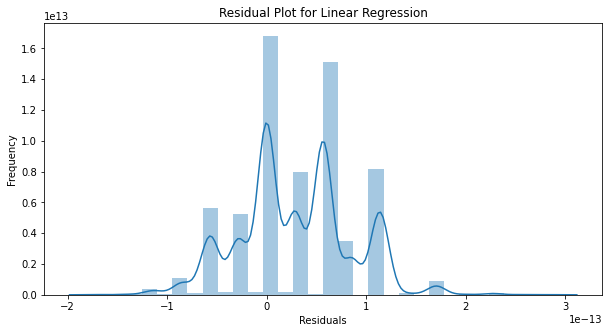

In [46]:
plt.figure(figsize=(10, 5))
sns.distplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



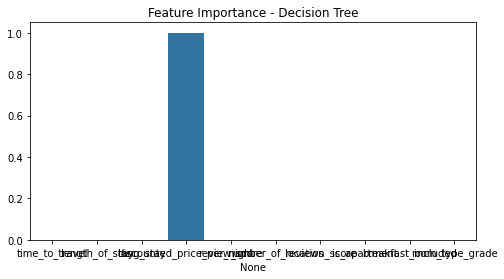

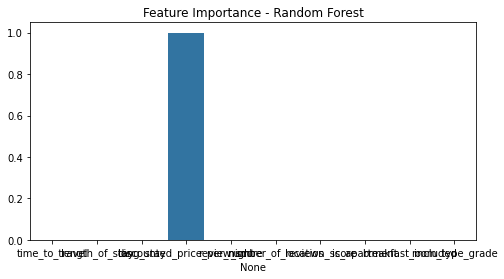

In [47]:
# Feature Importance for Decision Tree and Random Forest
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    feature_importance = model.feature_importances_
    plt.figure(figsize=(8, 4))
    sns.barplot(x=X.columns, y=feature_importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Neural Network Model 1
class NeuralNet1(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Neural Network Model 2 with Embedding
class NeuralNet2(nn.Module):
    def __init__(self, input_dim, embedding_dim=5):
        super(NeuralNet2, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.embedding(x))
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, test_loader, epochs=50):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(test_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train NeuralNet1
model1 = NeuralNet1(X_train_scaled.shape[1])
train_model(model1, train_loader, test_loader)

# Train NeuralNet2
model2 = NeuralNet2(X_train_scaled.shape[1])
train_model(model2, train_loader, test_loader)


Epoch 1/50, Validation Loss: 319.3197
Epoch 2/50, Validation Loss: 115.2489
Epoch 3/50, Validation Loss: 49.6945
Epoch 4/50, Validation Loss: 24.8653
Epoch 5/50, Validation Loss: 12.6737
Epoch 6/50, Validation Loss: 6.0694
Epoch 7/50, Validation Loss: 3.0256
Epoch 8/50, Validation Loss: 7.2723
Epoch 9/50, Validation Loss: 1.8461
Epoch 10/50, Validation Loss: 0.7214
Epoch 11/50, Validation Loss: 1.4252
Epoch 12/50, Validation Loss: 0.4232
Epoch 13/50, Validation Loss: 0.6947
Epoch 14/50, Validation Loss: 3.9924
Epoch 15/50, Validation Loss: 0.7782
Epoch 16/50, Validation Loss: 0.1450
Epoch 17/50, Validation Loss: 1.7236
Epoch 18/50, Validation Loss: 0.2749
Epoch 19/50, Validation Loss: 0.1307
Epoch 20/50, Validation Loss: 2.8651
Epoch 21/50, Validation Loss: 0.4600
Epoch 22/50, Validation Loss: 0.1481
Epoch 23/50, Validation Loss: 0.2071
Epoch 24/50, Validation Loss: 0.2076
Epoch 25/50, Validation Loss: 0.4289
Epoch 26/50, Validation Loss: 0.2788
Epoch 27/50, Validation Loss: 0.2248
Epo

In [76]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
    
    # Scatter plot: Predictions vs Actual
    plt.figure()
    plt.scatter(y_test.numpy(), y_pred, alpha=0.5, color='blue')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')  # Identity line
    plt.show()

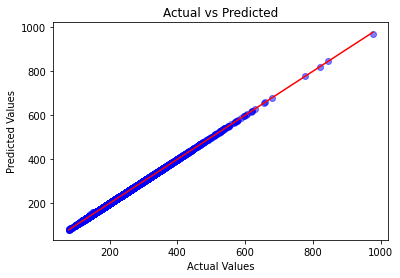

In [77]:
evaluate_model(model1, X_test_tensor, y_test_tensor)

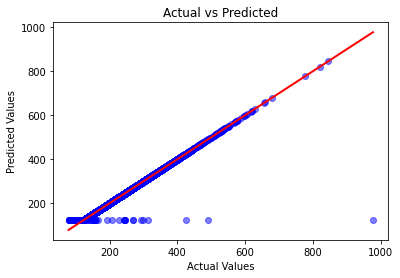

In [53]:
evaluate_model(model2, X_test_tensor, y_test_tensor)